<a href="https://colab.research.google.com/github/amsa10/Conv-segmentation/blob/main/seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
from tqdm import tqdm
import tensorflow as tf

# Download the pretrained model
model_url = 'yourmodel'
model_path = '/content/pretrained_model.h5'

try:
    response = requests.get(model_url, stream=True)
    response.raise_for_status()  # Raise an exception for HTTP errors
    total_size = int(response.headers.get('content-length', 0))

    with open(model_path, 'wb') as file:
        with tqdm(total=total_size, unit='B', unit_scale=True, unit_divisor=1024) as progress_bar:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    file.write(chunk)
                    progress_bar.update(len(chunk))

    print(f"File downloaded successfully and saved to {model_path}")

    # Load the model
    model = tf.keras.models.load_model(model_path, compile=False)
    print("Model loaded successfully.")

except requests.exceptions.RequestException as e:
    print(f"Failed to download file: {e}")

except Exception as e:
    print(f"An error occurred: {e}")



100%|██████████| 418M/418M [03:57<00:00, 1.84MB/s]


File downloaded successfully and saved to /content/pretrained_model.h5
Model loaded successfully.


In [2]:
import cv2
import numpy as np
import os

# Directory containing the patches
patch_dir = 'sample'

# List the files in the directory
files = os.listdir(patch_dir)

# Create a dictionary to store the patches
patches = {
    'blue': [],
    'green': [],
    'red': [],
    'nir': []
}

# Function to resize the patch
def resize_patch(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)  # Read as grayscale to handle individual bands
    resized_img = cv2.resize(img, (192, 192), interpolation=cv2.INTER_AREA)
    return resized_img

# Load and resize each patch
for file in files:
    if 'blue' in file:
        patches['blue'].append(resize_patch(os.path.join(patch_dir, file)))
    elif 'green' in file:
        patches['green'].append(resize_patch(os.path.join(patch_dir, file)))
    elif 'red' in file:
        patches['red'].append(resize_patch(os.path.join(patch_dir, file)))
    elif 'nir' in file:
        patches['nir'].append(resize_patch(os.path.join(patch_dir, file)))

# Stack the corresponding spectral bands

stacked_patches = []
for i in range(len(patches['blue'])):
    # Stack the patches along the last axis
    stacked_patch = np.stack((
        patches['blue'][i],
        patches['green'][i],
        patches['red'][i],
        patches['nir'][i]
    ), axis=-1)
    stacked_patches.append(stacked_patch)


# Example: Print the shape of the first stacked patch to verify
print(f'Shape of the first stacked patch: {stacked_patches[0].shape}')


Shape of the first stacked patch: (192, 192, 4)


In [3]:
import numpy as np

# Stack the normalized patches into a single NumPy array
stacked_patches_reshaped = np.stack(stacked_patches, axis=0)

# Now predict using the reshaped data
predictions = model.predict(stacked_patches_reshaped)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [56]:
import numpy as np

# Assuming 'binary_array' is your binary mask
num_positive = np.sum(predictions == 1)
num_negative = np.sum(predictions == 0.5)

print(f"Number of positive pixels: {num_positive}")
print(f"Number of negative pixels: {num_negative}")


Number of positive pixels: 28439
Number of negative pixels: 0


In [57]:
import numpy as np
from skimage.transform import resize

# Example variable (replace with your actual patch)
predicted_patch = predictions  # Replace with actual single patch
global_threshold = 0.5
new_size = (384, 384)

def process_patch(patch, threshold, new_size):
    # Remove single-dimensional entries from the shape of the patch
    patch = patch.squeeze()  # Shape: (192, 192)

    # Binarize the patch
    binary_patch = (patch > threshold)

    # Resize the patch
    resized_patch = resize(binary_patch, new_size, mode='reflect', anti_aliasing=False)



    return resized_patch

# Assuming 'predicted_patch' is passed to the function process_patch
processed_patch= process_patch(predicted_patch, global_threshold, new_size)

# Print the shape of the processed patch
print("Shape of processed patch:", processed_patch.shape)



Shape of processed patch: (384, 384)


Jaccard Index: 0.7749
Precision: 0.7909
Recall: 0.9745
Specificity: 0.5686
Overall Accuracy: 0.8227


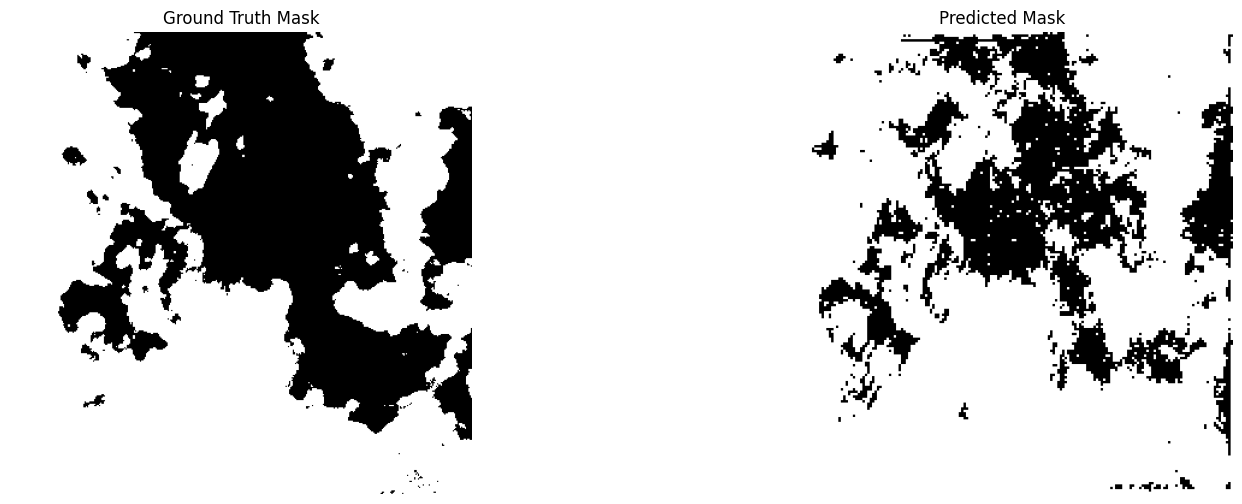

In [58]:
import numpy as np
import tensorflow as tf
from skimage import io
from skimage.color import rgb2gray
from skimage.transform import resize
import matplotlib.pyplot as plt

# Load and normalize the ground truth image
ground_truth_path = '/content/sample/gt_patch_100_5_by_12_LC08_L1TP_061017_20160720_20170223_01_T1.tiff'
ground_truth = io.imread(ground_truth_path)
ground_truth = (ground_truth == 255).astype(np.uint8)


# Ensure ground_truth_binary and processed_patch are the same size
if processed_patch.shape != ground_truth.shape:
    processed_patch = resize(processed_patch, ground_truth.shape, mode='reflect', anti_aliasing=False)

# Compute metrics
def compute_metrics(predicted_mask, ground_truth_mask):
    TP = np.sum((predicted_mask == 1) & (ground_truth_mask == 1))
    TN = np.sum((predicted_mask == 0) & (ground_truth_mask == 0))
    FP = np.sum((predicted_mask == 1) & (ground_truth_mask == 0))
    FN = np.sum((predicted_mask == 0) & (ground_truth_mask == 1))

    jaccard_index = TP / (TP + FN + FP) if (TP + FN + FP) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    overall_accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0

    return jaccard_index, precision, recall, specificity, overall_accuracy

# Compute metrics
jaccard_index, precision, recall, specificity, overall_accuracy = compute_metrics(processed_patch, ground_truth)

# Print metrics
print(f"Jaccard Index: {jaccard_index:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Overall Accuracy: {overall_accuracy:.4f}")

# Plot the results for visual inspection
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
ax[0].imshow(ground_truth, cmap='gray')
ax[0].set_title('Ground Truth Mask')
ax[0].axis('off')

ax[1].imshow(processed_patch, cmap='gray')
ax[1].set_title('Predicted Mask')
ax[1].axis('off')

plt.show()



In [9]:
!pip install gdown
!gdown --id yourlink -O img.tiff


/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1beO8YaOR5ZNPtV4ftmC8bzlygjBaJGrX
To: /content/img.tiff
100% 53.1M/53.1M [00:02<00:00, 21.2MB/s]


In [10]:
pip install patchify rasterio matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 30.2 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Metadata: {'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 14456, 'height': 1800, 'count': 1, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0)}


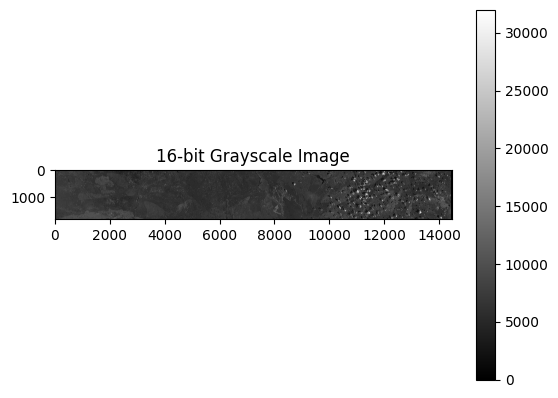

In [11]:
import rasterio
import matplotlib.pyplot as plt

# Open the TIFF file
with rasterio.open('/content/img.tiff') as src:
    # Read the image data
    img_array = src.read(1)  # Read the first band

    # Get image metadata
    metadata = src.meta
    print('Metadata:', metadata)

# Display the image using matplotlib
plt.imshow(img_array, cmap='gray')
plt.title('16-bit Grayscale Image')
plt.colorbar()  # To show the color scale
plt.show()




In [79]:
import numpy as np
from PIL import Image
from skimage.transform import resize
import tensorflow as tf  # Or import your model library
import matplotlib.pyplot as plt

# Load the image
image_path = '/content/img.tiff'
image = Image.open(image_path)

# Convert to NumPy array
img_array = np.array(image)

# Normalize to range [0, 1]
#img_array = img_array / 65535.0

# Expand dimensions for single-channel to RGBNIR (assuming dummy channels)
rgbnir_array = np.stack([img_array] * 4, axis=-1)  # Assuming dummy RGBNIR

# Define functions to extract patches and resize them
def extract_patches(img, patch_size, resize_to):
    patches = []
    h, w, _ = img.shape
    for i in range(0, h - patch_size + 1, patch_size):
        for j in range(0, w - patch_size + 1, patch_size):
            patch = img[i:i+patch_size, j:j+patch_size]
            patch_resized = resize(patch, resize_to, mode='reflect')
            patches.append(patch_resized)
    return np.array(patches)

# Extract and resize patches
patches = extract_patches(rgbnir_array, patch_size=384, resize_to=(192, 192, 4))

# Load your pretrained model
# Replace this with your model loading code
predictions = model.predict(patches)

# Predict cloud masks predictions = model.predict(patches)





5/5 ━━━━━━━━━━━━━━━━━━━━ 94s 16s/step


In [83]:
predictions.shape

(148, 192, 192, 1)

Full cloud mask saved to /content/cloud_mask_full.png


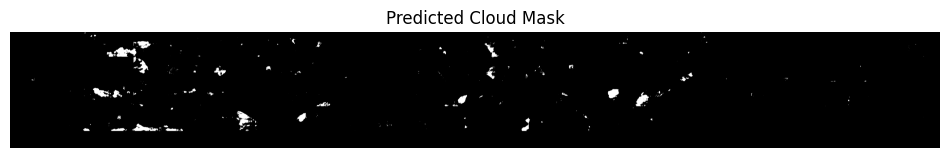

In [84]:
import numpy as np
import tensorflow as tf
from PIL import Image
from skimage.transform import resize
import matplotlib.pyplot as plt

# Metadata
original_width = 14456
original_height = 1800
patch_size = 384
resized_patch_size = 192
global_threshold = 0.047


# Binarize the predictions using the global threshold
binary_predictions = predictions > global_threshold

# Resize each patch to 384x384
resized_predictions = np.zeros((binary_predictions.shape[0], patch_size, patch_size), dtype=np.float32)
for i in range(binary_predictions.shape[0]):
    resized_predictions[i] = resize(binary_predictions[i, :, :, 0], (patch_size, patch_size), mode='constant')

# Define the number of patches
num_patches_x = original_width // patch_size
num_patches_y = original_height // patch_size

# Initialize arrays for reconstruction
cloud_mask_full = np.zeros((original_height, original_width), dtype=np.float32)
count_map = np.zeros((original_height, original_width), dtype=np.float32)

# Reconstruct the full image
for i in range(num_patches_y):
    for j in range(num_patches_x):
        start_y = i * patch_size
        start_x = j * patch_size
        end_y = start_y + patch_size
        end_x = start_x + patch_size

        # Ensure the end indices do not exceed the image dimensions
        if end_y > original_height:
            end_y = original_height
        if end_x > original_width:
            end_x = original_width

        # Calculate patch indices in resized_predictions
        patch_idx = i * num_patches_x + j
        patch = resized_predictions[patch_idx]

        # Add patch to full image and update count map
        cloud_mask_full[start_y:end_y, start_x:end_x] += patch[:end_y - start_y, :end_x - start_x]
        count_map[start_y:end_y, start_x:end_x] += 1

# Normalize the full cloud mask
cloud_mask_full /= np.maximum(count_map, 1)

# Save the cloud mask as an image
output_mask_path = '/content/cloud_mask_full.png'
plt.imsave(output_mask_path, cloud_mask_full, cmap='gray')

print(f"Full cloud mask saved to {output_mask_path}")

# Display the full cloud mask
plt.figure(figsize=(12, 6))
plt.title('Predicted Cloud Mask')
plt.imshow(cloud_mask_full, cmap='gray')
plt.axis('off')
plt.show()



Full cloud mask saved to /content/cloud_mask_full.png


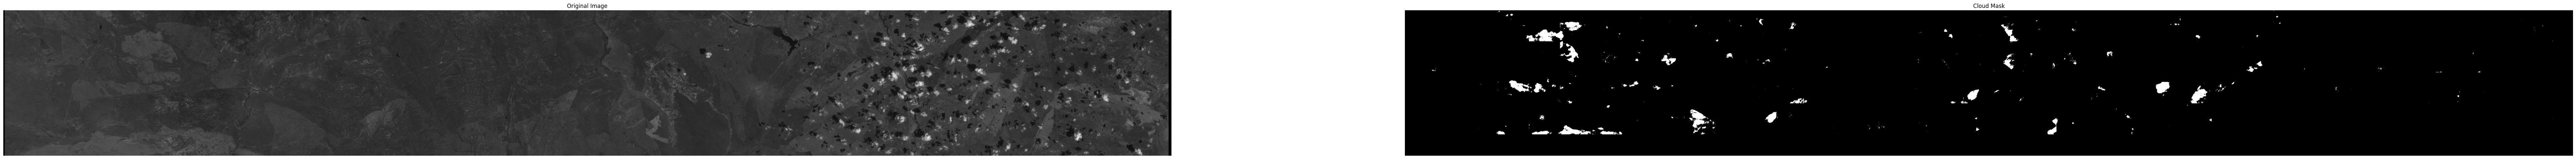

In [85]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load the original image
original_image_path = '/content/img.tiff'
original_image = Image.open(original_image_path)

# Assuming cloud_mask_full is already computed and normalized
# Normalize the image to the [0, 255] range for saving
cloud_mask_normalized = (cloud_mask_full - cloud_mask_full.min()) / (cloud_mask_full.max() - cloud_mask_full.min())
cloud_mask_uint8 = (cloud_mask_normalized * 255).astype(np.uint8)

# Save the cloud mask using PIL
output_mask_path = '/content/cloud_mask_full.png'
Image.fromarray(cloud_mask_uint8, mode='L').save(output_mask_path)

print(f"Full cloud mask saved to {output_mask_path}")

# Display the original image and cloud mask side by side
plt.figure(figsize=(100, 100))

# Display the original image
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(original_image, cmap='gray')
plt.axis('off')

# Display the cloud mask
plt.subplot(1, 2, 2)
plt.title('Cloud Mask')
plt.imshow(cloud_mask_full, cmap='gray', vmin=0, vmax=1)
plt.axis('off')

plt.show()
